# COLMAP Demo
Website Link: https://colmap.github.io/

COLMAP CLI commands to run in case you have known camera intrinsics and the input is a video (sequence of frames)

```bash
DATASET_PATH=your/path/to/the/datafolder/

colmap feature_extractor --database_path $DATASET_PATH/database.db --image_path $DATASET_PATH/images --ImageReader.camera_model "SIMPLE_PINHOLE" --ImageReader.single_camera true --ImageReader.camera_params "<your f, cx, cy>" --SiftExtraction.use_gpu 0

colmap sequential_matcher --database_path $DATASET_PATH/database.db

mkdir $DATASET_PATH/sparse

colmap mapper --database_path $DATASET_PATH/database.db --image_path $DATASET_PATH/images/ --output_path $DATASET_PATH/sparse --Mapper.ba_refine_extra_params 0 --Mapper.ba_refine_principal_point 0 --Mapper.ba_refine_focal_length 0



Try it out using one of COLMAP's [sample datasets](https://onedrive.live.com/?authkey=%21AAQumsDDwZBIW3w&id=C58A258D760E1B58%2146879&cid=C58A258D760E1B58)!

# Python Bindings for COLMAP

Split in 2 parts:
1. colmap/pycolmap: https://github.com/colmap/colmap/tree/main/pycolmap
2. colmap/scripts/python/ :https://github.com/colmap/colmap/tree/main/scripts/python

Collected neatly under one hood in [HLoc](https://github.com/cvg/Hierarchical-Localization)

*   Well built, but not well documented. Essentially self-documenting with a lot of examples.
*   Can figure out API for any task using examples from this repo as well as their [PixSFM](https://github.com/cvg/pixel-perfect-sfm)
*  Supercharges COLMAP with features and matchers of your choice - SuperPoint/SuperGlue, DISK, LoFTR, LightGlue, and more!



# Hierarchical Localization
This section of the notebook has been directly adapted from the [hloc toolbox](https://github.com/cvg/Hierarchical-Localization/blob/master/demo.ipynb). Kudos to the excellent developers/researchers at CVG @ ETH Zurich for open-sourcing this work.

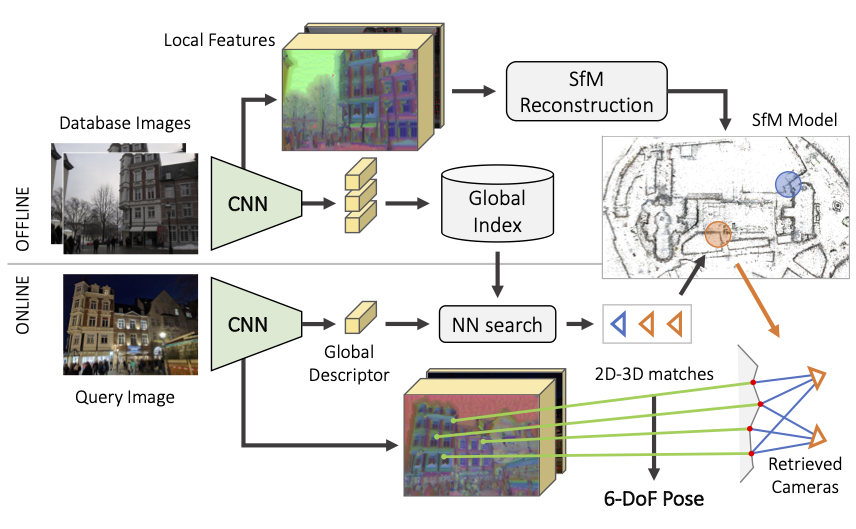

In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In [ ]:
!git clone --quiet --recursive https://github.com/cvg/Hierarchical-Localization/
%cd Hierarchical-Localization
!pip install --progress-bar off --quiet -e .
!pip install --progress-bar off --quiet --upgrade plotly

import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

# Setup
Here we define some output paths. We will use SuperPoint local features with the SuperGlue matcher, but it's easy to switch to other features like SIFT or R2D2.

In [ ]:
images = Path('datasets/sacre_coeur')
outputs = Path('outputs/demo/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['disk']
matcher_conf = match_features.confs['disk+lightglue']

# 3D mapping
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

In [ ]:
references = [str(p.relative_to(images)) for p in (images / 'mapping/').iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [ ]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

The we run incremental Structure-from-Motion...

In [ ]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)

and display the reconstructed 3D model:

In [ ]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

We also visualize which keypoints were triangulated into the 3D model.

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)

# Localization
Now that we have a 3D map of the scene, we can localize any image. To demonstrate this, we download [a night-time image from Wikimedia](https://commons.wikimedia.org/wiki/File:Paris_-_Basilique_du_Sacr%C3%A9_Coeur,_Montmartre_-_panoramio.jpg).

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/5/53/Paris_-_Basilique_du_Sacr%C3%A9_Coeur%2C_Montmartre_-_panoramio.jpg"
# try other queries by uncommenting their url
# url = "https://upload.wikimedia.org/wikipedia/commons/5/59/Basilique_du_Sacr%C3%A9-C%C5%93ur_%285430392880%29.jpg"
# url = "https://upload.wikimedia.org/wikipedia/commons/8/8e/Sacr%C3%A9_C%C5%93ur_at_night%21_%285865355326%29.jpg"
query = 'query/night.jpg'
!mkdir -p $images/query && wget $url -O $images/$query -q
plot_images([read_image(images / query)], dpi=75)

Again, we extract features for the query and match them exhaustively with all mapping images that were successfully reconstructed.

In [ ]:
references_registered = [model.images[i].name for i in model.reg_image_ids()]
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references_registered)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters.

In [ ]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(n).image_id for n in references_registered]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map.

In [ ]:
pose = pycolmap.Image(cam_from_world=ret['cam_from_world'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query, fill=True)
# visualize 2D-3D correspodences
import numpy as np
inl_3d = np.array([model.points3D[pid].xyz for pid in np.array(log['points3D_ids'])[ret['inliers']]])
viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=query)
fig.show()